# **MDA project**

# **Setup and import the data**

In [ ]:
#setup
!pip install pyspark

In [2]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import functions 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [4]:
#import require libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from scipy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [5]:
# import data from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
# !unzip "/content/drive/My Drive/MDA2022ProjectData.zip" -d "/content/drive/My Drive/MDA2022ProjectData"

In [7]:
# read data and creat dataframe
df=spark.read.csv('/content/drive/My Drive/MDA2022ProjectData/MDA2022ProjectData.csv',header=True)

In [8]:
#  showing top 5 rows of df
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010047|      284|       63455590|     63455590|               6|       161|2021-12-22 00:59:30|
|   22010054|      284|       63566637|     64111706|               7|       161|2021-12-22 01:24:58|
|   22010057|      284|       63653636|     63653636|               6|       161|2021-12-22 00:46:37|
|   22010039|      284|       63562975|     64111706|               7|       161|2021-12-22 00:27:32|
|   22010053|      284|       63634047|     64111706|               7|       161|2021-12-22 01:29:24|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



In [9]:
#drop useless columns
df = df[['DEVICE_CODE','FINAL_CAR_KEY','PASS_DAY_TIME']]
df.show(5)

+-----------+-------------+-------------------+
|DEVICE_CODE|FINAL_CAR_KEY|      PASS_DAY_TIME|
+-----------+-------------+-------------------+
|   22010054|     64111706|2021-12-22 01:24:18|
|   22010040|     64111706|2021-12-22 01:40:29|
|   22010079|     63348486|2021-12-22 01:14:32|
|   22010053|     64111706|2021-12-22 00:32:33|
|   22010044|     64111706|2021-12-22 01:25:06|
+-----------+-------------+-------------------+
only showing top 5 rows



In [10]:
#add columns that show time and day of the week
# Sunday:1 to Saturday:7 
df_1 = df.withColumn('DAY_OF_WEEK',dayofweek(df.PASS_DAY_TIME))
df_2 = df_1.withColumn('HOUR', hour(df_1.PASS_DAY_TIME))

In [12]:
df_2.show(5)

+-----------+-------------+-------------------+-----------+----+
|DEVICE_CODE|FINAL_CAR_KEY|      PASS_DAY_TIME|DAY_OF_WEEK|HOUR|
+-----------+-------------+-------------------+-----------+----+
|   22010054|     64111706|2021-12-22 01:24:18|          4|   1|
|   22010040|     64111706|2021-12-22 01:40:29|          4|   1|
|   22010079|     63348486|2021-12-22 01:14:32|          4|   1|
|   22010053|     64111706|2021-12-22 00:32:33|          4|   0|
|   22010044|     64111706|2021-12-22 01:25:06|          4|   1|
+-----------+-------------+-------------------+-----------+----+
only showing top 5 rows



# **Collaborative filtering on cameras**

In [ ]:
#creat  vector  7*24
vec_7_24= np.zeros(shape=(df_2.select(df_2.DEVICE_CODE).distinct().count(),7,24))

In [ ]:
#creat dataframe with  DAY_OF_WEEK|HOUR|count columns
device = [i.DEVICE_CODE for i in df_2.select('DEVICE_CODE').distinct().collect()]
df_3 = df_2.groupby(['DEVICE_CODE','DAY_OF_WEEK','HOUR']).count()
df_3.show(5)

+-----------+-----------+----+-----+
|DEVICE_CODE|DAY_OF_WEEK|HOUR|count|
+-----------+-----------+----+-----+
|    8106011|          4|  12|    1|
|     631357|          4|   7|    1|
|     631639|          4|  11|    1|
|     202101|          4|   6|    1|
|  100701090|          4|   6|    1|
+-----------+-----------+----+-----+
only showing top 5 rows



In [ ]:
#indexing the cameras
device_dict = {}
for i, devicecode in enumerate(device):
    device_dict[i] = devicecode
device_dict = {j: i for i, j in device_dict.items()}


In [ ]:
df_3_list=df_3.collect()

In [ ]:
#fill the matrix based on the dataframe fields
for cam,d,h,num in df_3_list:
  vec_7_24[device_dict[cam],d-1,h-1] = num

In [ ]:
# now we use CF on cameras
user_item_matrix = np.zeros(shape=(len(device),7*24))
for i in range(len(device)):
   user_item_matrix[i] = vec_7_24[i].ravel()

In [ ]:
#calculating correlation by corr() methode
user_item_df = pd.DataFrame(user_item_matrix)
cor_df = user_item_df.T.corr()
cor_df

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,500,501,502
0,1.000000,0.078795,-0.052688,-0.055431,0.017425,0.210939,-0.015515,0.030815,-0.083390,0.126806,...,-0.028858,0.196203,-0.028858,-0.061548,-0.028858,-0.028858,-0.028858,-0.028858,-0.040934,-0.028858
1,0.078795,1.000000,0.212567,0.013783,0.058303,0.013821,0.113017,0.250670,0.026741,0.048675,...,0.032118,0.110420,-0.059336,0.124227,0.215024,-0.059336,0.032118,-0.059336,-0.084166,-0.059336
2,-0.052688,0.212567,1.000000,0.047531,0.044383,0.046801,-0.048782,0.171729,0.236197,0.037092,...,-0.039631,-0.056215,-0.039631,-0.084524,-0.039631,-0.039631,-0.039631,-0.039631,-0.056215,0.099078
3,-0.055431,0.013783,0.047531,1.000000,0.053943,-0.061252,-0.085126,0.042674,0.230584,-0.000689,...,-0.020747,-0.029429,-0.020747,-0.044249,-0.020747,-0.020747,-0.020747,-0.020747,-0.029429,-0.020747
4,0.017425,0.058303,0.044383,0.053943,1.000000,0.087831,0.038020,0.151798,0.130359,-0.001053,...,0.173135,-0.044967,-0.031701,0.057208,-0.031701,-0.031701,-0.031701,-0.031701,0.100310,-0.031701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,-0.028858,-0.059336,-0.039631,-0.020747,-0.031701,-0.017678,-0.024569,-0.044933,-0.017303,0.111224,...,-0.005988,-0.008494,-0.005988,0.293733,-0.005988,1.000000,-0.005988,-0.005988,-0.008494,-0.005988
499,-0.028858,0.032118,-0.039631,-0.020747,-0.031701,-0.017678,-0.024569,-0.044933,-0.017303,-0.033626,...,-0.005988,-0.008494,-0.005988,-0.012771,-0.005988,-0.005988,1.000000,-0.005988,-0.008494,-0.005988
500,-0.028858,-0.059336,-0.039631,-0.020747,-0.031701,-0.017678,-0.024569,-0.044933,-0.017303,-0.033626,...,-0.005988,-0.008494,-0.005988,-0.012771,-0.005988,-0.005988,-0.005988,1.000000,-0.008494,-0.005988
501,-0.040934,-0.084166,-0.056215,-0.029429,0.100310,0.396205,-0.034850,-0.063736,-0.024544,-0.047697,...,-0.008494,-0.012048,-0.008494,-0.018115,-0.008494,-0.008494,-0.008494,-0.008494,1.000000,-0.008494


In [ ]:
cor_df = np.tril(cor_df,-1)
pd.DataFrame(cor_df)

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,500,501,502
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.078795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.052688,0.212567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-0.055431,0.013783,0.047531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.017425,0.058303,0.044383,0.053943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,-0.028858,-0.059336,-0.039631,-0.020747,-0.031701,-0.017678,-0.024569,-0.044933,-0.017303,0.111224,...,-0.005988,-0.008494,-0.005988,0.293733,-0.005988,0.000000,0.000000,0.000000,0.000000,0.0
499,-0.028858,0.032118,-0.039631,-0.020747,-0.031701,-0.017678,-0.024569,-0.044933,-0.017303,-0.033626,...,-0.005988,-0.008494,-0.005988,-0.012771,-0.005988,-0.005988,0.000000,0.000000,0.000000,0.0
500,-0.028858,-0.059336,-0.039631,-0.020747,-0.031701,-0.017678,-0.024569,-0.044933,-0.017303,-0.033626,...,-0.005988,-0.008494,-0.005988,-0.012771,-0.005988,-0.005988,-0.005988,0.000000,0.000000,0.0
501,-0.040934,-0.084166,-0.056215,-0.029429,0.100310,0.396205,-0.034850,-0.063736,-0.024544,-0.047697,...,-0.008494,-0.012048,-0.008494,-0.018115,-0.008494,-0.008494,-0.008494,-0.008494,0.000000,0.0


In [ ]:
idx = np.unravel_index(np.argsort(cor_df.ravel())[-100:], cor_df.shape)

In [ ]:
#creat dataframe of similar cameras
idx_0 = idx[0].tolist()
idx_1 = idx[1].tolist()
device_ser = pd.Series(device)
ac_ser_0 = device_ser[idx_0].values
ac_ser_1 = device_ser[idx_1].values
sim_cameras = pd.DataFrame({'Camera 1': ac_ser_0, 'Camera 2': list(ac_ser_1)},columns=['Camera 1', 'Camera 2'])
sim_cameras

,Camera 1,Camera 2
0,100701235,22010135
1,100701181,631782
2,230105,631358
3,100701120,100701235
4,631783,157
...,...,...
95,212001,101
96,631881,635623
97,711018,230202
98,810210,107


Text(0, 0.5, 'DEVICE_CODE:22010092')

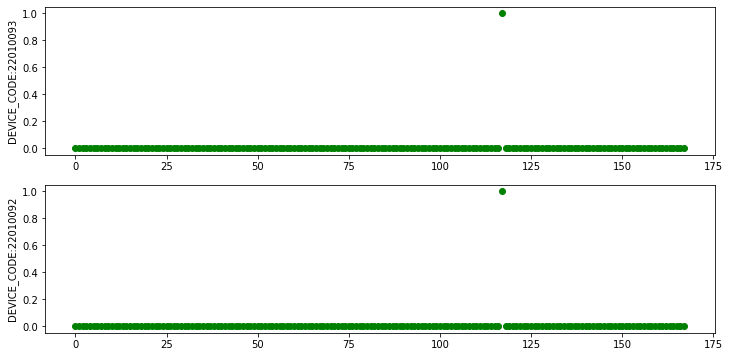

In [ ]:
#plot similar cameras
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(range(0,24*7),user_item_matrix[device_dict['204701']],'go')
plt.ylabel('DEVICE_CODE:22010093')
plt.subplot(2,1,2)
plt.plot(range(0,24*7),user_item_matrix[device_dict['900122']],'go')
plt.ylabel('DEVICE_CODE:22010092')

# **Collaborative filtering on cars**

In [ ]:
path = device
list_temp=df_2.select('FINAL_CAR_KEY').distinct().collect()
cars =  [i.FINAL_CAR_KEY for i in list_temp]
matrix = np.zeros((len(cars),len(path)))

In [ ]:
df_4 = df_2.groupBy('FINAL_CAR_KEY').agg(functions.collect_list("DEVICE_CODE"))
df_4.show(5)

+-------------+-------------------------+
|FINAL_CAR_KEY|collect_list(DEVICE_CODE)|
+-------------+-------------------------+
|         null|     [631830, 900247, ...|
|     10000048|                 [900183]|
|     10000061|         [900256, 900256]|
|     10000155|      [100700862, 900174]|
|    100001807|                 [900269]|
+-------------+-------------------------+
only showing top 5 rows



In [ ]:
#indexing the cars
car_dict = {}
for i, carkey in enumerate(cars):
  car_dict[i] = carkey
car_dict = {j: i for i, j in car_dict.items()}

In [ ]:
df_4_list=df_4.collect()

Row(FINAL_CAR_KEY='10000048', collect_list(DEVICE_CODE)=['900183'])

In [ ]:
for j,m in df_4_list:
  for i in m:
    idx = device.index(i)
    matrix[car_dict[j]][idx] = 1
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# calculating correlation by corr() methode
matrix_df = pd.DataFrame(matrix)
matrix_df = matrix_df[matrix_df.iloc[:, 1:].sum(axis=1)>=]
cor_df_2 = matrix_df.T.corr()
cor_df_2 = np.tril(cor_df_2,-1)
idx_2 = np.unravel_index(np.argsort(cor_df_2.ravel())[-100:], cor_df_2.shape)
idx_0_2 = idx_2[0].tolist()
idx_1_2 = idx_2[1].tolist()
car_ser = pd.Series(cars)
ac_ser_0_2 = car_ser[idx_0_2].values
ac_ser_1_2 = car_ser[idx_1_2].values
#creat dataframe of similar cars
sim_cars = pd.DataFrame({'Car 1': ac_ser_0_2, 'Car 2': list(ac_ser_1_2)}, columns=['Car 1', 'Car 2'])

Text(0, 0.5, 'CAR_KEY:16173590')

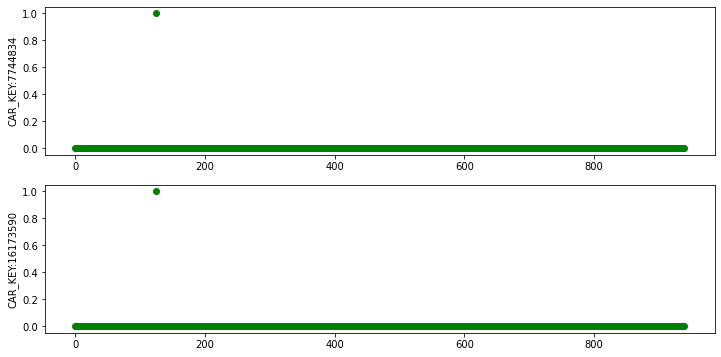

In [ ]:
#plot two similar cars
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(range(0,len(device)),matrix[car_dict['7744834']],'go')
plt.ylabel('CAR_KEY:7744834')
plt.subplot(2,1,2)
plt.plot(range(0,len(device)),matrix[car_dict['16173590']],'go')
plt.ylabel('CAR_KEY:16173590')

# **Car similarity by cosine distance**

In [ ]:
df_a=df.withColumn("date",to_date("PASS_DAY_TIME"))
df_a.show(5)

+-----------+-------------+-------------------+----------+
|DEVICE_CODE|FINAL_CAR_KEY|      PASS_DAY_TIME|      date|
+-----------+-------------+-------------------+----------+
|   22010059|     63315887|2021-12-22 00:51:16|2021-12-22|
|  100701235|     47807908|2021-12-22 01:07:42|2021-12-22|
|     635607|     81726547|2021-12-22 00:05:34|2021-12-22|
|   10015301|     36037995|2021-12-22 00:51:14|2021-12-22|
|   22010044|     64111706|2021-12-22 01:30:33|2021-12-22|
+-----------+-------------+-------------------+----------+
only showing top 5 rows



In [ ]:
df_a_rdd=df_a.rdd.map(lambda x: ((x[1],str(x[3])),x[0]))  # (key=(plate,date),value=DEVICE_CODE)

In [ ]:
df_a_rdd.take(5)

[(('63315887', '2021-12-22'), '22010059'),
 (('47807908', '2021-12-22'), '100701235'),
 (('81726547', '2021-12-22'), '635607'),
 (('36037995', '2021-12-22'), '10015301'),
 (('64111706', '2021-12-22'), '22010044')]

In [ ]:
rdd_a_1=df_a_rdd.groupByKey().mapValues(set).mapValues(list) #(key=(plate,date),value = [Device Code List])

In [ ]:
rdd_a_1.take(5)

[(('84772646', '2021-12-22'), ['100700820']),
 (('84755468', '2021-12-22'), ['100701096', '22010095']),
 (('83441842', '2021-12-22'), ['900241']),
 (('7657081', '2021-12-22'), ['900149']),
 (('29484171', '2021-12-22'), ['202601'])]

In [ ]:
uniq_cam=df_a.select('DEVICE_CODE').distinct().collect() #determine unique camera

In [ ]:
ind = np.random.randint(0,len(uniq_cam),4) #creating random index for choosing random camera
hypo_path = np.array(uniq_cam)[(ind).astype(int)] #creating a hypothetical path

In [ ]:
hypo_path

array([['900155'],
       ['212001'],
       ['22010073'],
       ['22009915']], dtype='<U9')

In [ ]:
#finding cars that their Device Code List  have at least a camera on hypothetical path
rdd_similar_path=rdd_a_1.filter(lambda x: set(hypo_path[0]).issubset(set(x[1])) or set(hypo_path[1]).issubset(set(x[1])) or set(hypo_path[2]).issubset(set(x[1])) or set(hypo_path[3]).issubset(set(x[1])))

In [ ]:
#convert hypo_path to set for next cell
set_hypo=set()
for i in range(len(hypo_path)):
    set_hypo.add(hypo_path.tolist()[i][0])

In [ ]:
#( key =cos(theta), value = ((plate,date),[Device Code List]) )
rdd_cosine_similarity=rdd_similar_path.map(lambda x: ((len(set_hypo.intersection(set(x[1])))/(np.sqrt(len(set_hypo)) * np.sqrt(len(set(x[1]))) )).round(3),(x[0],x[1])) )

In [ ]:
#sort by cosine similarity
sorted(rdd_cosine_similarity.take(20),reverse=True)

[(0.5, (('94177400', '2021-12-23'), ['900155'])),
 (0.5, (('92618743', '2021-12-22'), ['900155'])),
 (0.5, (('88011827', '2021-12-24'), ['900155'])),
 (0.5, (('8540129', '2021-12-24'), ['900155'])),
 (0.5, (('63349828', '2021-12-23'), ['900155'])),
 (0.5, (('61937158', '2021-12-22'), ['212001'])),
 (0.5, (('50078902', '2021-12-23'), ['900155'])),
 (0.5, (('35282772', '2021-12-22'), ['900155'])),
 (0.5, (('31973122', '2021-12-24'), ['900155'])),
 (0.5, (('29603337', '2021-12-24'), ['900155'])),
 (0.5, (('23192263', '2021-12-24'), ['900155'])),
 (0.5, (('22879913', '2021-12-23'), ['900155'])),
 (0.5, (('19047993', '2021-12-23'), ['900155'])),
 (0.5, (('17863807', '2021-12-22'), ['22010073'])),
 (0.5, (('16415071', '2021-12-25'), ['900155'])),
 (0.5, (('15200215', '2021-12-24'), ['900155'])),
 (0.5, (('14304296', '2021-12-24'), ['900155'])),
 (0.5, (('13847493', '2021-12-25'), ['900155'])),
 (0.5, (('10873263', '2021-12-24'), ['900155'])),
 (0.354, (('7889187', '2021-12-24'), ['900155', '

# **SVD decomposition**

In [ ]:
from scipy.linalg import svd 
matrix_df_normalise = matrix_df - np.asarray([(np.mean(matrix_df, 1))]).T
Utility = matrix_df_normalise.T / np.sqrt(matrix_df.shape[0] - 1)
U, S, V = svd(Utility)
pd.DataFrame(np.diag(S))

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,936,937,938,939
0,0.532425,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000,0.395324,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000,0.337711,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.000000,0.000000,0.318462,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000,0.000000,0.000000,0.000000,0.318165,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.401736e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
936,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.372258e-17,0.000000e+00,0.000000e+00,0.000000e+00
937,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.450720e-17,0.000000e+00,0.000000e+00
938,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,9.165517e-18,0.000000e+00


# **Pixie**

In [ ]:
#creat  KV_car_camera : (key=(FINAL_CAR_KEY,DEVICE_CODE),1)
KV_car_camera = df.rdd.map(lambda x: ((x[1],x[0]),1))
reduced_car_camera=KV_car_camera.reduceByKey(lambda x,y: x+y)

In [ ]:
#creat graphs
camera_car_rdd=reduced_car_camera.map(lambda x:(x[0][1],(x[0][0],x[1]))).groupByKey()
camera_car_list=camera_car_rdd.mapValues(dict).collect()                  
car_camera_rdd=reduced_car_camera.map(lambda x:(x[0][0],(x[0][1],x[1]))).groupByKey()
car_camera_list=car_camera_rdd.mapValues(dict).collect()                  

In [ ]:
#a:probability , lim:threshold ,iter:number of steps
def Pixie_sim(pin,board,query,a,lim,iter):
  pin_node=query
  visit_pin_s={}
  for i in range(0,iter):
      s=pin[pin_node]
      r=board[random.choices(list(s.keys()),list(s.values()))[0]]
      pin_node=random.choices(list(r.keys()),list(r.values()))[0]
      if pin_node in visit_pin_s:
        visit_pin_s[pin_node]=visit_pin_s[pin_node]+1
      else:
        visit_pin_s[pin_node]=1
      if random.random()<a:
        pin_node=query
  sim_item={}
  for pin_node in visit_pin_s:
    if visit_pin_s[pin_node]>lim:
      sim_item[pin_node]=visit_pin_s[pin_node]
  return sim_item

In [ ]:
#similarity on cars
car_camera_dict=dict(car_camera_list)
camera_car_dict=dict(camera_car_list)
cars=list(car_camera_dict.keys())
sim_cars=Pixie_sim(car_camera_dict,camera_car_dict,random.choices(cars)[0],0.55,20,6000)
print(str(random.choices(cars)[0]))
sim_cars

31112426


{'20332201': 212,
 '88682899': 191,
 '64111706': 1998,
 '95686695': 201,
 '8589324': 209,
 '16993854': 205,
 '16694581': 225,
 '12521319': 193,
 '14004295': 194,
 '31112426': 203,
 '9833773': 191,
 '17268428': 212,
 '82807364': 192,
 '14067234': 196,
 '101329458': 197}

In [ ]:
#similarity on cameras
cameras=list(camera_car_dict.keys())
sim_cam=Pixie_sim(camera_car_dict,car_camera_dict,random.choices(cameras)[0],0.55,80,6000)
print(str(random.choices(cameras)[0]))
sim_cam

211701


{'211701': 2116, '22010054': 95, '22010040': 110, '114': 84, '22010053': 142}

# **clustering**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
feature_matrix = user_item_matrix
standard_scaler= StandardScaler()
scaled_feature_matrix = standard_scaler.fit_transform(feature_matrix)
kmeans_kwargs = {"init":"random","n_init":10,"max_iter":250,"random_state":52}
e = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,**kmeans_kwargs)
    kmeans.fit(scaled_feature_matrix)
    e.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

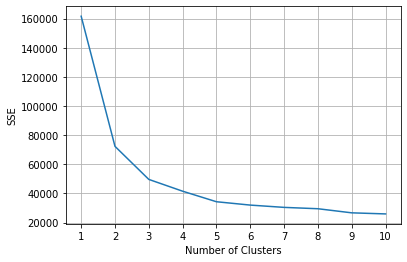

In [ ]:
plt.plot(range(1, 11), e)
plt.grid()
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [ ]:
labels = kmeans.labels_.tolist()
np.array(labels)

array([6, 1, 1, 1, 5, 6, 6, 1, 6, 1, 1, 6, 1, 7, 2, 6, 5, 7, 1, 4, 1, 1,
       1, 1, 6, 6, 7, 4, 6, 3, 1, 4, 1, 4, 1, 1, 1, 4, 1, 1, 9, 1, 1, 6,
       5, 1, 1, 5, 6, 3, 4, 9, 1, 8, 4, 1, 1, 4, 7, 1, 6, 1, 6, 1, 7, 1,
       1, 1, 1, 1, 1, 1, 1, 5, 6, 1, 1, 4, 1, 1, 1, 4, 1, 5, 7, 1, 6, 4,
       6, 1, 7, 6, 1, 1, 6, 6, 5, 4, 1, 6, 1, 2, 7, 1, 6, 1, 1, 1, 5, 1,
       1, 1, 5, 4, 6, 1, 8, 3, 5, 1, 1, 6, 6, 1, 7, 1, 1, 4, 4, 1, 7, 1,
       8, 7, 5, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 7, 4, 6, 4, 4, 7, 5, 1, 7,
       6, 1, 1, 1, 4, 2, 4, 1, 1, 4, 4, 3, 1, 1, 4, 7, 6, 6, 1, 1, 6, 1,
       7, 7, 7, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 6, 7, 3, 1, 1, 6, 1, 6, 1,
       6, 8, 6, 1, 1, 1, 8, 7, 1, 1, 1, 4, 4, 1, 6, 4, 1, 1, 1, 3, 8, 6,
       1, 1, 1, 1, 5, 6, 7, 8, 1, 1, 1, 1, 1, 1, 6, 1, 1, 0, 1, 5, 1, 1,
       1, 4, 4, 7, 6, 1, 6, 6, 4, 1, 1, 8, 4, 4, 7, 1, 9, 1, 1, 1, 6, 1,
       1, 4, 6, 4, 4, 1, 6, 4, 1, 1, 2, 6, 1, 4, 7, 1, 6, 6, 6, 1, 1, 1,
       1, 5, 4, 1, 4, 6, 1, 8, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
def key_find(arg):
    for key, value in device_dict.items():
         if arg == value:
             return key
    return "non"
label0 = []
label1 = []
label2 = []
label3 = []
label4 = []
label5 = []
label6 = []
label7 = []
label8 = []
label9 = []

In [ ]:
for i in range(len(labels)):
  if labels[i]==0:
    label0.append(key_find(i))
  elif labels[i]==1:
    label1.append(key_find(i))
  elif labels[i]==2:
    label2.append(key_find(i))
  elif labels[i]==3:
    label3.append(key_find(i))
  elif labels[i]==4:
    label4.append(key_find(i))
  elif labels[i]==5:
    label5.append(key_find(i))
  elif labels[i]==6:
    label6.append(key_find(i))
  elif labels[i]==7:
    label7.append(key_find(i))
  elif labels[i]==8:
    label8.append(key_find(i))
  elif labels[i]==9:
    label9.append(key_find(i))

In [ ]:
pd.DataFrame(label4, columns=['Label 4'])

,Label 4
0,232
1,155
2,200902
3,209103
4,631346
...,...
67,100701269
68,100701262
69,100700835
70,900199


# **frequent-items(A-priori)**



In [ ]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm

In [ ]:
#add column 'date' to dataframe
df_a=df.withColumn("date",to_date("PASS_DAY_TIME"))
df_a.show(3)

+-----------+-------------+-------------------+----------+
|DEVICE_CODE|FINAL_CAR_KEY|      PASS_DAY_TIME|      date|
+-----------+-------------+-------------------+----------+
|   22010054|     64111706|2021-12-22 01:24:18|2021-12-22|
|   22010040|     64111706|2021-12-22 01:40:29|2021-12-22|
|   22010079|     63348486|2021-12-22 01:14:32|2021-12-22|
+-----------+-------------+-------------------+----------+
only showing top 3 rows



In [ ]:
#creat rdd (key=(plate,date),value=DEVICE_CODE)
df_a_rdd=df_a.rdd.map(lambda x: ((x[1],str(x[3])),x[0]))

In [ ]:
#groupby the rdd and creat the new rdd with new format (key=(plate,date),value=[list of device codes])
rdd_a_1=df_a_rdd.groupByKey().mapValues(set).mapValues(list)

In [ ]:
#creat baskets of cameras
rdd_of_baskets=rdd_a_1.map(lambda x:x[1])

In [ ]:
basket_numbers=rdd_of_baskets.count()

In [ ]:
baskets_list = rdd_of_baskets.collect()

In [ ]:
#creat rdd of items
rdd_of_items = rdd_of_baskets.flatMap(lambda x:x)

#creat (key=item, value=1) for each item
KV_of_items=rdd_of_items.map(lambda x :(x,1))

#count each item with reduceByKey (key = item, value =number of the item) 
number_of_item = KV_of_items.reduceByKey(lambda x, y: x + y) 

In [ ]:
#sort the items by their support
number_of_item_sorted_list=sorted(number_of_item.collect(),key=lambda x: x[1],reverse=True)
number_of_item_sorted_list

[('900212', 258396),
 ('900244', 250597),
 ('100700853', 214275),
 ('900269', 207356),
 ('900222', 182983),
 ('631634', 173842),
 ('900101', 163240),
 ('900142', 151506),
 ('100700841', 143324),
 ('631633', 142285),
 ('900268', 139104),
 ('900225', 138451),
 ('900155', 135421),
 ('900246', 132204),
 ('900236', 131893),
 ('900164', 122542),
 ('900191', 119686),
 ('100700804', 110369),
 ('631357', 109736),
 ('900234', 108221),
 ('100700864', 100147),
 ('900218', 99848),
 ('900207', 99468),
 ('100700820', 94865),
 ('900273', 89021),
 ('900266', 86486),
 ('900233', 81621),
 ('900202', 81042),
 ('900259', 80329),
 ('900217', 78644),
 ('114', 78000),
 ('100700839', 75986),
 ('900226', 75567),
 ('631829', 75275),
 ('631795', 74991),
 ('900185', 74988),
 ('100700881', 73956),
 ('22010040', 73507),
 ('900102', 73083),
 ('631765', 71195),
 ('631368', 71094),
 ('900243', 69807),
 ('900149', 69613),
 ('900167', 69318),
 ('900215', 67545),
 ('900235', 66107),
 ('900141', 65372),
 ('900214', 64205),

In [ ]:
support=number_of_item.map(lambda x:x[1])

In [ ]:
support.sum()/support.count()

12469.257900101937

In [ ]:
#find frequant items
support_threshold= 35000
frequent_items=number_of_item.filter(lambda x :x[1]>=support_threshold)

In [ ]:
#sort the frequant items by their support
frequent_items_sorted_list=sorted(frequent_items.collect(),key=lambda x: x[1],reverse=True)
frequent_items_sorted_list

[('900212', 258396),
 ('900244', 250597),
 ('100700853', 214275),
 ('900269', 207356),
 ('900222', 182983),
 ('631634', 173842),
 ('900101', 163240),
 ('900142', 151506),
 ('100700841', 143324),
 ('631633', 142285),
 ('900268', 139104),
 ('900225', 138451),
 ('900155', 135421),
 ('900246', 132204),
 ('900236', 131893),
 ('900164', 122542),
 ('900191', 119686),
 ('100700804', 110369),
 ('631357', 109736),
 ('900234', 108221),
 ('100700864', 100147),
 ('900218', 99848),
 ('900207', 99468),
 ('100700820', 94865),
 ('900273', 89021),
 ('900266', 86486),
 ('900233', 81621),
 ('900202', 81042),
 ('900259', 80329),
 ('900217', 78644),
 ('114', 78000),
 ('100700839', 75986),
 ('900226', 75567),
 ('631829', 75275),
 ('631795', 74991),
 ('900185', 74988),
 ('100700881', 73956),
 ('22010040', 73507),
 ('900102', 73083),
 ('631765', 71195),
 ('631368', 71094),
 ('900243', 69807),
 ('900149', 69613),
 ('900167', 69318),
 ('900215', 67545),
 ('900235', 66107),
 ('900141', 65372),
 ('900214', 64205),

In [ ]:
#this function creat subsets of given set
def findsubsets(sett, n):
    return list(itertools.combinations(sett, n))

In [ ]:
#this function calculate support of given itemset
def support_calc(itemset):
    support=0
    for i in range(basket_numbers):
        if set(itemset).issubset(set(baskets_list[i])):
            support=support+1
            
    return support

In [ ]:
frequent_items_whithout_support=[]
for i in range(len(frequent_items_sorted_list)):
    frequent_items_whithout_support.append(frequent_items_sorted_list[i][0])

In [ ]:
#find candidate pairs
candidate_pairs = findsubsets(frequent_items_whithout_support,2)
len(candidate_pairs)

5995

In [ ]:
candidate_pairs[0:10]

In [ ]:
#calculate support of candidate pairs
candidate_pairs_KV=[]
for i in range(len(candidate_pairs)):
    supp=support_calc(candidate_pairs[i])
    candidate_pairs_KV.append((candidate_pairs[i],supp))

In [ ]:
candidate_pairs_KV[0:10]

[(('900212', '900244'), 19198),
 (('900212', '100700853'), 6707),
 (('900212', '900269'), 2429),
 (('900212', '900222'), 1926),
 (('900212', '631634'), 4025),
 (('900212', '900101'), 4266),
 (('900212', '900142'), 9430),
 (('900212', '100700841'), 1681),
 (('900212', '631633'), 6006),
 (('900212', '900268'), 1576)]

In [ ]:
#creat rdd of candidate pairs (key = candidate pairs, value = support )
candidate_pairs_rdd=sc.parallelize(candidate_pairs_KV)

In [ ]:
#calculate the average support
candidate_pairs_supports = candidate_pairs_rdd.map(lambda x :x[1])
candidate_pairs_supports.sum() / candidate_pairs_supports.count()

489.2156862745098

In [ ]:
# filtering the candidate pairs and find frequent_pairs
support_threshold  = 1500
frequent_pairs = candidate_pairs_rdd.filter(lambda x:x[1]>support_threshold)

In [ ]:
#sort the candidate pairs by their support
frequent_pairs_sorted_list=sorted(frequent_pairs.collect(),key=lambda x: x[1],reverse=True)
frequent_pairs_sorted_list[0:15]

[(('900212', '900244'), 19198),
 (('900212', '900142'), 9430),
 (('100700853', '900142'), 8251),
 (('900244', '900142'), 6938),
 (('900269', '900225'), 6908),
 (('900244', '631633'), 6838),
 (('900212', '100700853'), 6707),
 (('900212', '631633'), 6006),
 (('900244', '100700853'), 5488),
 (('100700864', '900185'), 5335),
 (('631634', '900207'), 5085),
 (('900268', '900225'), 5042),
 (('900222', '900155'), 4734),
 (('900101', '100700841'), 4558),
 (('900244', '631634'), 4446)]

findig frequant triples

In [ ]:
#creat list of items that each item is in a frequant pair(at least)
frequent_pairs_splited=[]
for  i  in range(len(frequent_pairs_sorted_list)):
      frequent_pairs_splited.append(frequent_pairs_sorted_list[i][0][0])
      frequent_pairs_splited.append(frequent_pairs_sorted_list[i][0][1])

In [ ]:
#we will creat triplex subsets from member of this list
unique_frequent_pairs_splited= list(set(frequent_pairs_splited))

In [ ]:
#creat candidate triples with the member of frequent pairs
candidate_triples = findsubsets(unique_frequent_pairs_splited,3)

In [ ]:
candidate_triples[0:10]

[('900155', '900236', '900227'),
 ('900155', '900236', '900222'),
 ('900155', '900236', '900255'),
 ('900155', '900236', '22009977'),
 ('900155', '900236', '900215'),
 ('900155', '900236', '900142'),
 ('900155', '900236', '231'),
 ('900155', '900236', '203902'),
 ('900155', '900236', '900233'),
 ('900155', '900236', '100700804')]

In [ ]:
frequent_pairs_whithout_support=[]
for  i  in range(len(frequent_pairs_sorted_list)):
      frequent_pairs_whithout_support.append(frequent_pairs_sorted_list[i][0])

In [ ]:
#all binary subsets of a frequant triple should be frequant
#so we check this condition here and find final candidates
final_candidate_triples=[]
for i in tqdm(range(len(candidate_triples))):
    subs_of_candidate=findsubsets(candidate_triples[i],2)
    flag=0
    for j in range(len(frequent_pairs_whithout_support)):
        if subs_of_candidate[0]==frequent_pairs_whithout_support[j]:
            flag=flag+1
        if subs_of_candidate[1]==frequent_pairs_whithout_support[j]:
            flag=flag+1
        if subs_of_candidate[2]==frequent_pairs_whithout_support[j]:
            flag=flag+1
    if flag==3:
        final_candidate_triples.append(candidate_triples[i])

100%|██████████| 34220/34220 [00:01<00:00, 19158.35it/s]


In [ ]:
final_candidate_triples[0:5]

[('900222', '631634', '900225'),
 ('900222', '900246', '631829'),
 ('631634', '900207', '900202'),
 ('900101', '900268', '900259'),
 ('900212', '900268', '900225')]

In [ ]:
#find frequant triples from final candidates
support_threshold=1
frequant_triples_list=[]
for i in tqdm(range(len(final_candidate_triples))):
    supp=support_calc(final_candidate_triples[i])
    if supp>=support_threshold:
        frequant_triples_list.append((final_candidate_triples[i],supp))

100%|██████████| 9/9 [00:42<00:00,  4.77s/it]


In [ ]:
frequent_triples_sorted_list=sorted(frequant_triples_list,key=lambda x: x[1],reverse=True)
frequent_triples_sorted_list

[(('900268', '900225', '900259'), 247),
 (('900222', '900246', '631829'), 170),
 (('631634', '900207', '900202'), 139),
 (('900212', '900269', '900259'), 133),
 (('900101', '900268', '900259'), 120),
 (('900212', '900268', '900225'), 109),
 (('900212', '900268', '900259'), 106),
 (('900222', '631634', '900225'), 91),
 (('900212', '900225', '900259'), 73)]

# **PCA**

In [13]:
#creat  vector  7*24
vec_7_24= np.zeros(shape=(df_2.select(df_2.DEVICE_CODE).distinct().count(),7,24))

In [21]:
device = [i.DEVICE_CODE for i in df_2.select('DEVICE_CODE').distinct().collect()]
df_3 = df_2.groupby(['DEVICE_CODE','DAY_OF_WEEK','HOUR']).count()
df_3.show(5)

+-----------+-----------+----+-----+
|DEVICE_CODE|DAY_OF_WEEK|HOUR|count|
+-----------+-----------+----+-----+
|     200502|          4|   0|   78|
|  100700836|          4|   2|   16|
|  100701100|          4|   3|   19|
|   22010079|          4|   3|   52|
|     900242|          4|   4|   38|
+-----------+-----------+----+-----+
only showing top 5 rows



In [22]:
#indexing the cameras
device_dict = {}
for i, devicecode in enumerate(device):
    device_dict[i] = devicecode
device_dict = {j: i for i, j in device_dict.items()}


In [23]:
df_3_list=df_3.collect()

In [24]:
for cam,d,h,num in df_3_list:
  vec_7_24[device_dict[cam],d-1,h-1] = num

In [25]:
data = vec_7_24.reshape(981,168)

In [29]:
#we standardized data  here,the mean of each dimension will be 0 and the std will be 1
data_standardized = StandardScaler().fit_transform(data)

In [30]:
#calculate the covariance matrix
covMatrix = np.matmul(data_standardized.T ,data_standardized)

# calculate the eigendecomposition of the covariance matrix
values, vector = eigh(covMatrix,eigvals=(covMatrix.shape[0]-2,covMatrix.shape[0]-1))

In [35]:
vector=vector.T

In [55]:
# applying the PCA
# we project each vector on the first two principal components
projectedData = np.matmul(vector, data_standardized.T)

In [56]:
kmeans_kwargs = {"init":"random","n_init":10,"max_iter":250,"random_state":52}
e = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,**kmeans_kwargs)
    kmeans.fit(projectedData.T)
    e.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

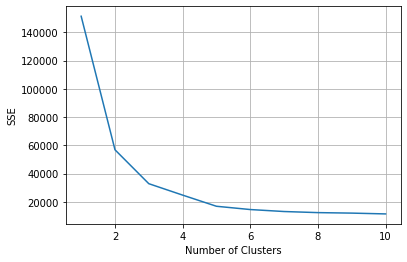

In [57]:
plt.plot(range(1, 11), e)
plt.grid()
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [58]:
#labels of cameras
labels = kmeans.labels_.tolist()

In [59]:
#creat dataframe of data after dimension reduction
reducedData = np.vstack((projectedData, labels)).T #Stack with labels
reducedData = pd.DataFrame(reducedData, columns = ['pca_1', 'pca_2', 'label'])
reducedData

,pca_1,pca_2,label
0,0.254625,-0.691969,2.0
1,-0.228706,5.460891,8.0
2,-0.233602,5.332592,8.0
3,-0.198528,5.482310,8.0
4,-0.008721,4.906783,8.0
...,...,...,...
976,-0.057246,3.972431,8.0
977,-0.128027,3.896782,8.0
978,-0.182643,5.526233,8.0
979,-0.251029,5.477000,8.0


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


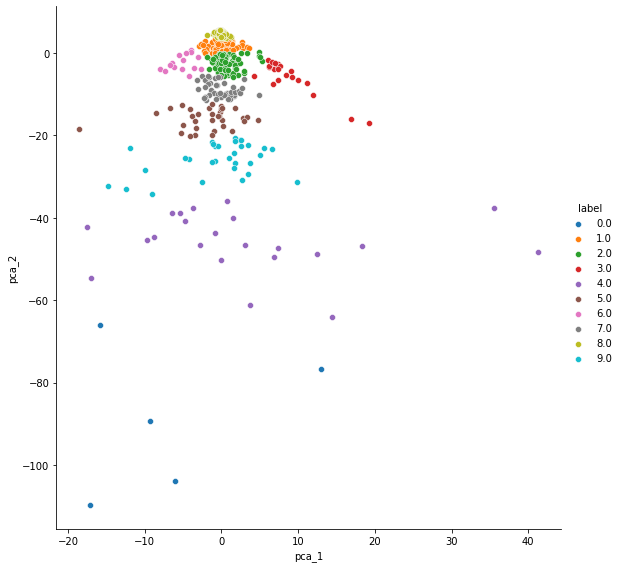

In [60]:
#plot the reducedData with clustering labels
sns.FacetGrid(reducedData, hue = 'label', size = 8) \
  .map(sns.scatterplot, 'pca_1', 'pca_2').add_legend()

In [61]:
#find device code from dictionary
def key_find(arg):
    for key, value in device_dict.items():
         if arg == value:
             return key
label0 = []
label1 = []
label2 = []
label3 = []
label4 = []
label5 = []
label6 = []
label7 = []
label8 = []
label9 = []

In [62]:
#find correspending labels
for i in range(len(labels)):
  if labels[i]==0:
    label0.append(key_find(i))
  elif labels[i]==1:
    label1.append(key_find(i))
  elif labels[i]==2:
    label2.append(key_find(i))
  elif labels[i]==3:
    label3.append(key_find(i))
  elif labels[i]==4:
    label4.append(key_find(i))
  elif labels[i]==5:
    label5.append(key_find(i))
  elif labels[i]==6:
    label6.append(key_find(i))
  elif labels[i]==7:
    label7.append(key_find(i))
  elif labels[i]==8:
    label8.append(key_find(i))
  elif labels[i]==9:
    label9.append(key_find(i))

In [64]:
pd.DataFrame(label6, columns=['Label 6'])

,Label 6
0,22010139
1,22010112
2,100701297
3,22010125
4,100701298
5,22010111
6,107301
7,22010110
8,22010122
9,205202
